In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/My Drive/проект/

/content/drive/My Drive/проект


In [3]:
%%capture
!unzip Berry.zip
!mv Berry train_berry
!find train_berry/Edi -size 0 -print0 |xargs -0 rm --
!find train_berry/Ine -size 0 -print0 |xargs -0 rm --

In [4]:
from glob import glob
from sklearn.model_selection import train_test_split

edi=glob('train_berry/Edi/*.jpg')
ine=glob('train_berry/Ine/*.jpg')

edi_train, edi_test = train_test_split(edi, test_size=0.01)
ine_train, ine_test = train_test_split(ine, test_size=0.01)

TRAIN_DIR='train_berry'
TEST_DIR='test_berry'

!mkdir test_berry

!mkdir test_berry/Edi
files=' '.join(edi_test)
!mv -t test_berry/Edi $files

!mkdir test_berry/Ine
files=' '.join(ine_test)
!mv -t test_berry/Ine $files

/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `mv -t test_berry/Edi train_berry/Edi/berry (200).jpg train_berry/Edi/berry (457).jpg train_berry/Edi/berry (8).jpg train_berry/Edi/berry (269).jpg train_berry/Edi/berry (361).jpg train_berry/Edi/berry (616).jpg train_berry/Edi/berry (31).jpg'
/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `mv -t test_berry/Ine train_berry/Ine/images (193).jpg train_berry/Ine/images (45).jpg train_berry/Ine/images (29) — копия.jpg train_berry/Ine/images (26).jpg train_berry/Ine/DSCN3845.jpg train_berry/Ine/69a590ee8fbcfd705c87ef3603b3793a.jpg train_berry/Ine/volchjya-yagoda-9.jpg'


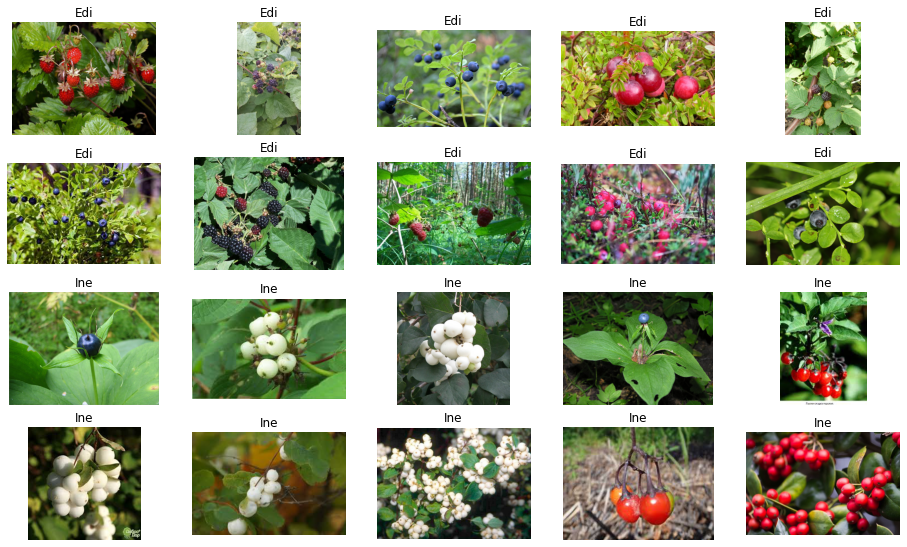

In [5]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

edi=np.random.choice(edi_train,10)
ine=np.random.choice(ine_train, 10)
data=np.concatenate((edi,ine))     #соединяет массивы вдоль указанной оси, возвращает массив
labels=10*['Edi']+10*['Ine']  

N, R, C = 25, 5, 5
plt.figure(figsize=(16,12))           #графический обьект, ширина 12 высота 9
for k,(src,label) in enumerate(zip(data,labels)):  #цикл применяет к итерируемой коллекци функцию, которая создает обьект (кортеж), состоящий из индекса элемента и самого элемента
  im=Image.open(src).convert('RGB')     #открывает и идентифицирует данный файл изображения          
  plt.subplot(R, C, k+1)   #создает фигиру и набор вложенных диаграмм 
  plt.title(label)
  plt.imshow(np.asarray(im))
  plt.axis('off')  #указывет ось

In [6]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout  #собираем слои(layers) для построения модели. обьединение пространственных данных.Dropout для борьбы с переобучением
from keras.applications.inception_v3 import InceptionV3, preprocess_input #нейронная сеть. 

CLASSES=2

base_model=InceptionV3(weights='imagenet', include_top=False) #используем модель, обученную на базе изображений imagenet (загрузили обученные веса). верхняя часть сетки выключена. 

x=base_model.output    #output - список выходных тензоров модели (тензор-основная структура данных в tensorflow; способ представления данных в глубоком обучении (n-ьерный массив))
x=GlobalAveragePooling2D(name='avg_pool')(x)  #операция средней подвыборки; 
x=Dense(512, activation='relu')(x)
x=Dropout(0.5)(x) 
x=Dense(512, activation='relu')(x)
x=Dropout(0.5)(x)
predictions=Dense(CLASSES, activation='softmax')(x)  # softmax -имя встроенной функции (активации), возвращает вероятность принадлежности изображения к классу
model=Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:   #model.layers - плоский список слоев, составляющих модель
  layer.trainable=False

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

87924736/87910968 [==============================] - 0s 0us/step


In [7]:
from keras.preprocessing.image import ImageDataGenerator #предобработка изображения 

WIDTH = 299
HEIGHT = 299
BATCH_SIZE = 32 #размер партии

# data prep
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,        
    height_shift_range=0.2,
    shear_range=0.2,              #интесивность сдвига (угол сдвига против часовйо стрелки в градусах)
    zoom_range=0.2,                # диапазон для случайного увеличения 
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
		batch_size=BATCH_SIZE,
		class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 1287 images belonging to 2 classes.
Found 0 images belonging to 2 classes.


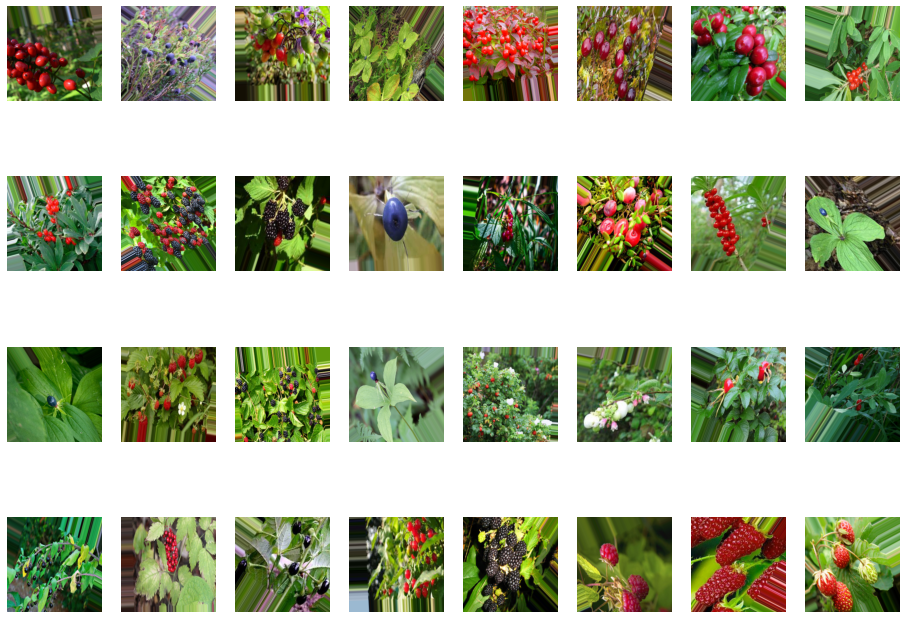

In [8]:
x_batch, y_batch = next(train_generator)   #?

plt.figure(figsize=(16, 12))
for k, (img, lbl) in enumerate(zip(x_batch, y_batch)):
    plt.subplot(4, 8, k+1)
    plt.imshow((img + 1) / 2)
    plt.axis('off')

In [ ]:
EPOCHS = 5
BATCH_SIZE = 32
STEPS_PER_EPOCH = 320
VALIDATION_STEPS = 64

MODEL_FILE = 'filename_berry_1_metric.h5'

history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS)
  
model.save(MODEL_FILE)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


Epoch 1/5
320/320 [==============================] - 55s 121ms/step - loss: 1.2607 - accuracy: 0.5843


In [ ]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


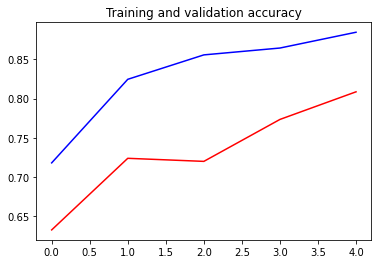

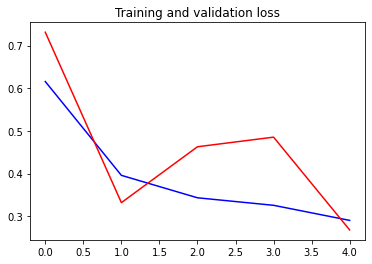

In [ ]:
def plot_training(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))   #range() генерирует ряд чисел в рамках заданного диапазона (от 0 до длины acc)
  
  plt.plot(epochs, acc, 'b')
  plt.plot(epochs, val_acc, 'r')
  plt.title('Training and validation accuracy')
  
  plt.figure()
  plt.plot(epochs, loss, 'b')
  plt.plot(epochs, val_loss, 'r-')
  plt.title('Training and validation loss')
  plt.show()
  
plot_training(history)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from keras.preprocessing import image
from keras.models import load_model


def predict(model, img):
    """Run model prediction on image
    Args:
        model: keras model
        img: PIL format image
    Returns:
        list of predicted labels and their probabilities 
    """
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]


def plot_preds(img, preds):
    """Displays image and the top-n predicted probabilities in a bar graph
    Args:
        preds: list of predicted labels and their probabilities
    """
    labels = ("edible", "poisonous")
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
    plt.figure(figsize=(8,8))
    plt.subplot(gs[0])
    plt.imshow(np.asarray(img))
    plt.subplot(gs[1])
    plt.barh([0, 1], preds, alpha=0.5)
    plt.yticks([0, 1], labels)
    plt.xlabel('Probability')
    plt.xlim(0, 1)
    plt.tight_layout()

In [ ]:
model = load_model(MODEL_FILE)

array([0.00164479, 0.9983552 ], dtype=float32)

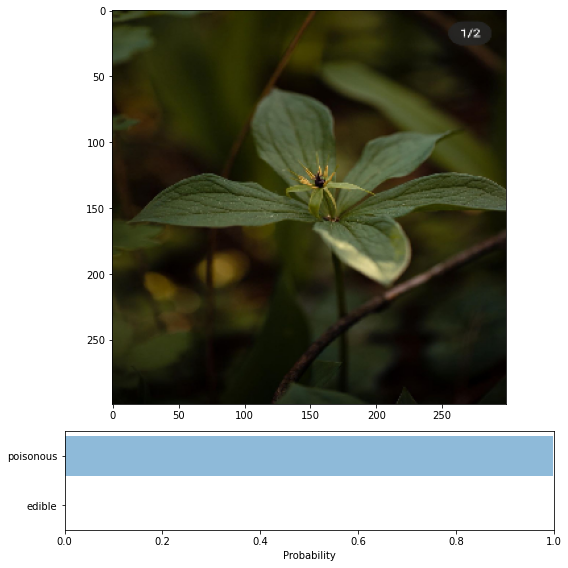

In [ ]:
img = image.load_img('/content/drive/My Drive/проект/презентация/vMfAyW7SBSg.jpg', target_size=(HEIGHT, WIDTH))
preds = predict(model, img)

plot_preds(np.asarray(img), preds)
preds

In [ ]:
!wget https://sun9-5.userapi.com/0VDozyttycMOJiHeBwXbaV_yi0pGpXB58XVMyA/v4-Mr7usoS8.jpg
!ls

--2020-07-21 11:47:54--  https://sun9-5.userapi.com/0VDozyttycMOJiHeBwXbaV_yi0pGpXB58XVMyA/v4-Mr7usoS8.jpg
Resolving sun9-5.userapi.com (sun9-5.userapi.com)... 87.240.185.132
Connecting to sun9-5.userapi.com (sun9-5.userapi.com)|87.240.185.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 614323 (600K) [image/jpeg]
Saving to: ‘v4-Mr7usoS8.jpg’

v4-Mr7usoS8.jpg     100%[===================>] 599.92K  --.-KB/s    in 0.1s    

2020-07-21 11:47:55 (4.27 MB/s) - ‘v4-Mr7usoS8.jpg’ saved [614323/614323]

0701w-4.jpg			      filename_berry5.h5
9e6152f732a225a3f54987f10d480f0c.jpg  filename_berry.h5
Bad				      filename_class.h5
Berry1.zip			      filename.h5
Berry.ipynb			      Good
Berry.zip			      Grib.zip
ccanniy_proect.ipynb		      kanttarelli-keltavahvero.jpg
class.ipynb			      mnist_cnn.py
class_test			      Mushroom
class_train			      test
Class.zip			      test_berry
filename_berry2.h5		      train
filename_berry3.h5		      train_berry
filename_berry4.h5

array([0.9923849 , 0.00761505], dtype=float32)

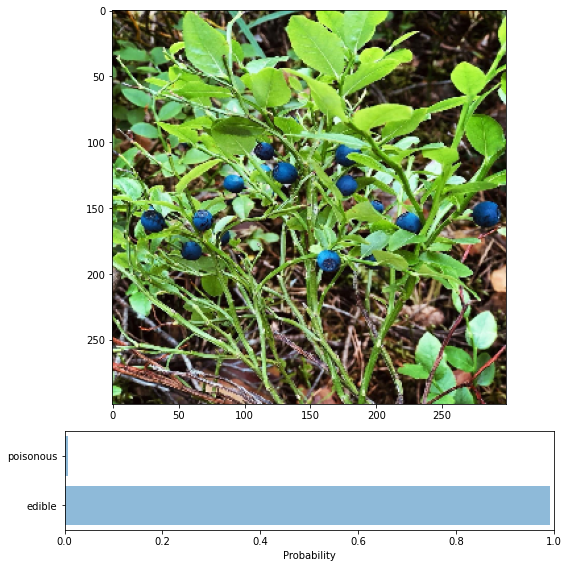

In [ ]:
img = image.load_img('v4-Mr7usoS8.jpg', target_size=(HEIGHT, WIDTH))
preds = predict(model, img)

plot_preds(np.asarray(img), preds)
preds

In [ ]:
!wget https://sun9-41.userapi.com/UkwwsiE_s6YW_UqDfrEqoLHoCFBlSUtM4Oj8-g/hXtEJLiS8Pg.jpg
!ls

--2020-07-21 11:49:04--  https://sun9-41.userapi.com/UkwwsiE_s6YW_UqDfrEqoLHoCFBlSUtM4Oj8-g/hXtEJLiS8Pg.jpg
Resolving sun9-41.userapi.com (sun9-41.userapi.com)... 93.186.227.148
Connecting to sun9-41.userapi.com (sun9-41.userapi.com)|93.186.227.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 530958 (519K) [image/jpeg]
Saving to: ‘hXtEJLiS8Pg.jpg’

hXtEJLiS8Pg.jpg     100%[===================>] 518.51K  3.35MB/s    in 0.2s    

2020-07-21 11:49:04 (3.35 MB/s) - ‘hXtEJLiS8Pg.jpg’ saved [530958/530958]

0701w-4.jpg			      filename_berry.h5
9e6152f732a225a3f54987f10d480f0c.jpg  filename_class.h5
Bad				      filename.h5
Berry1.zip			      Good
Berry.ipynb			      Grib.zip
Berry.zip			      hXtEJLiS8Pg.jpg
ccanniy_proect.ipynb		      kanttarelli-keltavahvero.jpg
class.ipynb			      mnist_cnn.py
class_test			      Mushroom
class_train			      test
Class.zip			      test_berry
filename_berry2.h5		      train
filename_berry3.h5		      train_berry
filename_berry4.

array([0.9985165 , 0.00148351], dtype=float32)

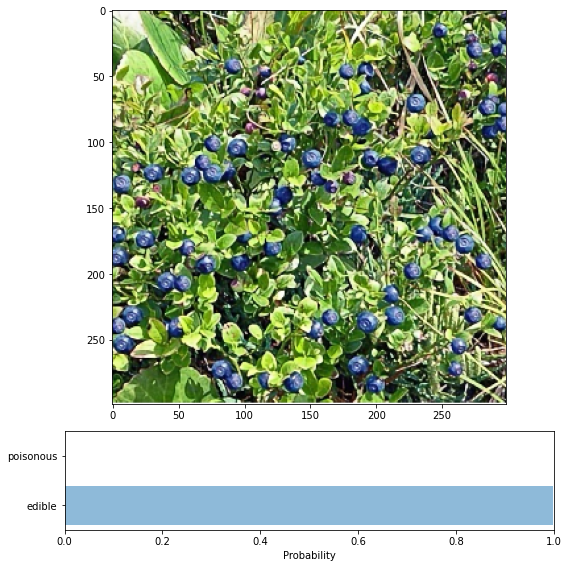

In [ ]:
img = image.load_img('hXtEJLiS8Pg.jpg', target_size=(HEIGHT, WIDTH))
preds = predict(model, img)

plot_preds(np.asarray(img), preds)
preds

In [ ]:
!wget https://sun1-22.userapi.com/jO95z3lJ5XdTSlpKecH3bzbL5VnGY8s10DqqkQ/pLckX_9w4GQ.jpg
!ls

--2020-07-21 11:50:03--  https://sun1-22.userapi.com/jO95z3lJ5XdTSlpKecH3bzbL5VnGY8s10DqqkQ/pLckX_9w4GQ.jpg
Resolving sun1-22.userapi.com (sun1-22.userapi.com)... 95.142.204.158
Connecting to sun1-22.userapi.com (sun1-22.userapi.com)|95.142.204.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 531905 (519K) [image/jpeg]
Saving to: ‘pLckX_9w4GQ.jpg’

pLckX_9w4GQ.jpg     100%[===================>] 519.44K  2.88MB/s    in 0.2s    

2020-07-21 11:50:03 (2.88 MB/s) - ‘pLckX_9w4GQ.jpg’ saved [531905/531905]

0701w-4.jpg			      filename_berry.h5
9e6152f732a225a3f54987f10d480f0c.jpg  filename_class.h5
Bad				      filename.h5
Berry1.zip			      Good
Berry.ipynb			      Grib.zip
Berry.zip			      hXtEJLiS8Pg.jpg
ccanniy_proect.ipynb		      kanttarelli-keltavahvero.jpg
class.ipynb			      mnist_cnn.py
class_test			      Mushroom
class_train			      pLckX_9w4GQ.jpg
Class.zip			      test
filename_berry2.h5		      test_berry
filename_berry3.h5		      train
filename_ber

array([9.999229e-01, 7.710801e-05], dtype=float32)

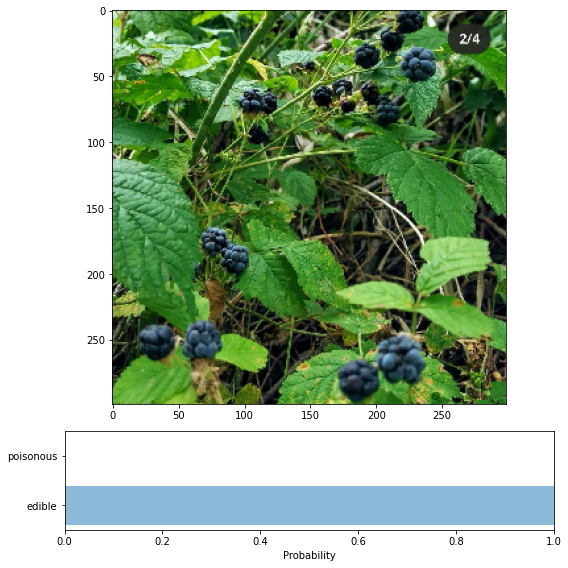

In [ ]:
img = image.load_img('pLckX_9w4GQ.jpg', target_size=(HEIGHT, WIDTH))
preds = predict(model, img)

plot_preds(np.asarray(img), preds)
preds

In [ ]:
!wget https://sun1-20.userapi.com/V2c98R3tnAPJiXp2gEh-c-qDNzuTt1JkPcjTgQ/B1f43Yw23Vc.jpg
!ls

--2020-07-21 11:50:57--  https://sun1-20.userapi.com/V2c98R3tnAPJiXp2gEh-c-qDNzuTt1JkPcjTgQ/B1f43Yw23Vc.jpg
Resolving sun1-20.userapi.com (sun1-20.userapi.com)... 95.142.204.183
Connecting to sun1-20.userapi.com (sun1-20.userapi.com)|95.142.204.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 499115 (487K) [image/jpeg]
Saving to: ‘B1f43Yw23Vc.jpg’

B1f43Yw23Vc.jpg     100%[===================>] 487.42K  2.77MB/s    in 0.2s    

2020-07-21 11:50:58 (2.77 MB/s) - ‘B1f43Yw23Vc.jpg’ saved [499115/499115]

0701w-4.jpg			      filename_berry.h5
9e6152f732a225a3f54987f10d480f0c.jpg  filename_class.h5
B1f43Yw23Vc.jpg			      filename.h5
Bad				      Good
Berry1.zip			      Grib.zip
Berry.ipynb			      hXtEJLiS8Pg.jpg
Berry.zip			      kanttarelli-keltavahvero.jpg
ccanniy_proect.ipynb		      mnist_cnn.py
class.ipynb			      Mushroom
class_test			      pLckX_9w4GQ.jpg
class_train			      test
Class.zip			      test_berry
filename_berry2.h5		      train
filename_berry

array([0.9895448 , 0.01045523], dtype=float32)

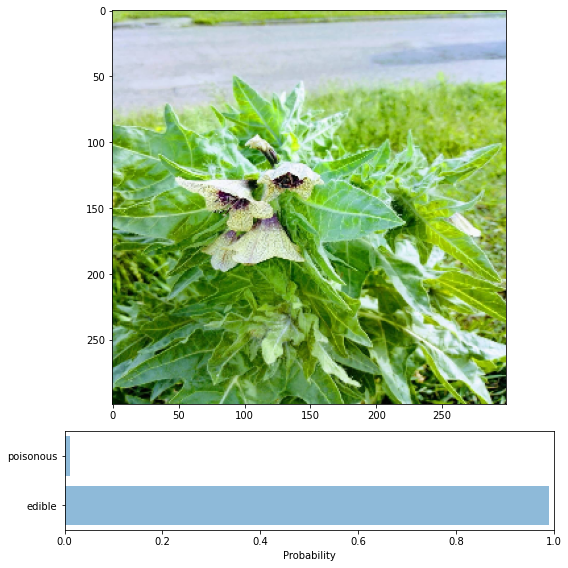

In [ ]:
img = image.load_img('B1f43Yw23Vc.jpg', target_size=(HEIGHT, WIDTH))
preds = predict(model, img)

plot_preds(np.asarray(img), preds)
preds

In [ ]:
!wget https://sun9-20.userapi.com/lc3zQI4SQOUxa3OMHLDVb4IkqFYcqbCR0JYIqQ/UtPMlEJFR_E.jpg
!ls

--2020-07-21 11:52:01--  https://sun9-20.userapi.com/lc3zQI4SQOUxa3OMHLDVb4IkqFYcqbCR0JYIqQ/UtPMlEJFR_E.jpg
Resolving sun9-20.userapi.com (sun9-20.userapi.com)... 93.186.227.131
Connecting to sun9-20.userapi.com (sun9-20.userapi.com)|93.186.227.131|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 250289 (244K) [image/jpeg]
Saving to: ‘UtPMlEJFR_E.jpg’

UtPMlEJFR_E.jpg     100%[===================>] 244.42K  --.-KB/s    in 0.1s    

2020-07-21 11:52:02 (2.42 MB/s) - ‘UtPMlEJFR_E.jpg’ saved [250289/250289]

0701w-4.jpg			      filename_berry.h5
9e6152f732a225a3f54987f10d480f0c.jpg  filename_class.h5
B1f43Yw23Vc.jpg			      filename.h5
Bad				      Good
Berry1.zip			      Grib.zip
Berry.ipynb			      hXtEJLiS8Pg.jpg
Berry.zip			      kanttarelli-keltavahvero.jpg
ccanniy_proect.ipynb		      mnist_cnn.py
class.ipynb			      Mushroom
class_test			      pLckX_9w4GQ.jpg
class_train			      test
Class.zip			      test_berry
filename_berry2.h5		      train
filename_berry

array([0.2025381, 0.7974619], dtype=float32)

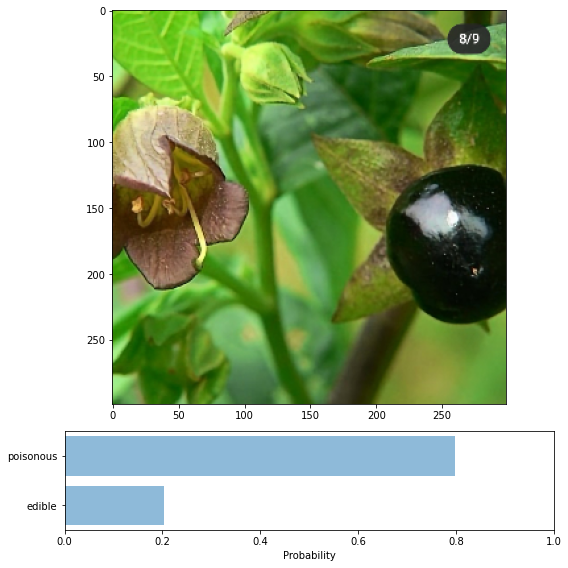

In [ ]:
img = image.load_img('UtPMlEJFR_E.jpg', target_size=(HEIGHT, WIDTH))
preds = predict(model, img)

plot_preds(np.asarray(img), preds)
preds

In [ ]:
!wget https://sun9-56.userapi.com/O_e_v6gafmvp7QYKbAgedUwXoEER79Of4sKi7g/vMfAyW7SBSg.jpg
!ls

--2020-07-21 11:53:04--  https://sun9-56.userapi.com/O_e_v6gafmvp7QYKbAgedUwXoEER79Of4sKi7g/vMfAyW7SBSg.jpg
Resolving sun9-56.userapi.com (sun9-56.userapi.com)... 87.240.185.159
Connecting to sun9-56.userapi.com (sun9-56.userapi.com)|87.240.185.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 243032 (237K) [image/jpeg]
Saving to: ‘vMfAyW7SBSg.jpg’

vMfAyW7SBSg.jpg     100%[===================>] 237.34K  --.-KB/s    in 0.1s    

2020-07-21 11:53:04 (2.43 MB/s) - ‘vMfAyW7SBSg.jpg’ saved [243032/243032]

0701w-4.jpg			      filename_class.h5
9e6152f732a225a3f54987f10d480f0c.jpg  filename.h5
B1f43Yw23Vc.jpg			      Good
Bad				      Grib.zip
Berry1.zip			      hXtEJLiS8Pg.jpg
Berry.ipynb			      kanttarelli-keltavahvero.jpg
Berry.zip			      mnist_cnn.py
ccanniy_proect.ipynb		      Mushroom
class.ipynb			      pLckX_9w4GQ.jpg
class_test			      test
class_train			      test_berry
Class.zip			      train
filename_berry2.h5		      train_berry
filename_berry3.h5		

array([0.04365131, 0.9563487 ], dtype=float32)

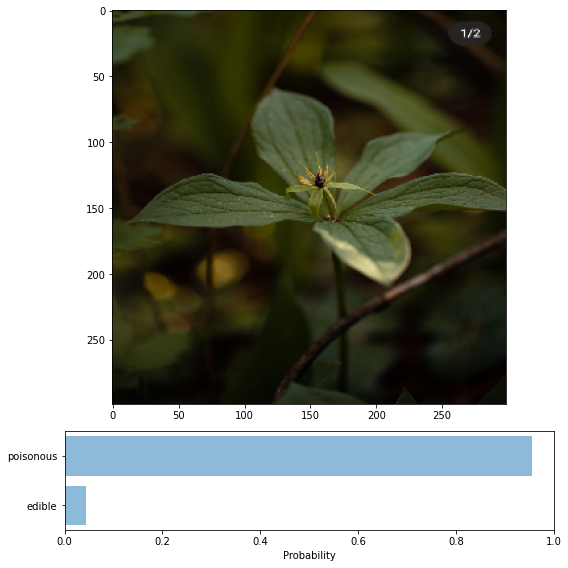

In [ ]:
img = image.load_img('vMfAyW7SBSg.jpg', target_size=(HEIGHT, WIDTH))
preds = predict(model, img)

plot_preds(np.asarray(img), preds)
preds

In [ ]:
!wget https://sun9-35.userapi.com/kP9ZmZc70G0rLQKoHVD7y7nmyqWRYV2fywqwww/l0KDUUGQPyo.jpg
!ls

--2020-07-21 11:53:57--  https://sun9-35.userapi.com/kP9ZmZc70G0rLQKoHVD7y7nmyqWRYV2fywqwww/l0KDUUGQPyo.jpg
Resolving sun9-35.userapi.com (sun9-35.userapi.com)... 93.186.227.146
Connecting to sun9-35.userapi.com (sun9-35.userapi.com)|93.186.227.146|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 304013 (297K) [image/jpeg]
Saving to: ‘l0KDUUGQPyo.jpg’

l0KDUUGQPyo.jpg     100%[===================>] 296.89K  --.-KB/s    in 0.1s    

2020-07-21 11:53:58 (2.87 MB/s) - ‘l0KDUUGQPyo.jpg’ saved [304013/304013]

0701w-4.jpg			      filename_class.h5
9e6152f732a225a3f54987f10d480f0c.jpg  filename.h5
B1f43Yw23Vc.jpg			      Good
Bad				      Grib.zip
Berry1.zip			      hXtEJLiS8Pg.jpg
Berry.ipynb			      kanttarelli-keltavahvero.jpg
Berry.zip			      l0KDUUGQPyo.jpg
ccanniy_proect.ipynb		      mnist_cnn.py
class.ipynb			      Mushroom
class_test			      pLckX_9w4GQ.jpg
class_train			      test
Class.zip			      test_berry
filename_berry2.h5		      train
filename_berry3.

array([0.00150914, 0.9984908 ], dtype=float32)

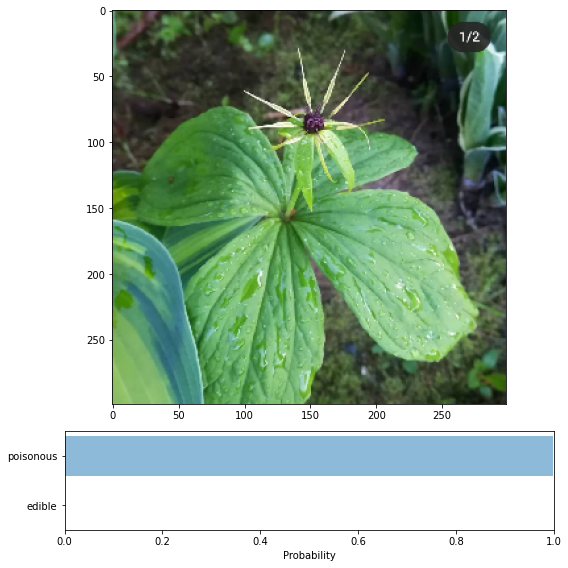

In [ ]:
img = image.load_img('l0KDUUGQPyo.jpg', target_size=(HEIGHT, WIDTH))
preds = predict(model, img)

plot_preds(np.asarray(img), preds)
preds

In [ ]:
!wget https://sun1-95.userapi.com/1TYLSo7h35HVoMiY9UZiqdItOAbO7fMVlq-bpw/ncX0t_t-pew.jpg
!ls

--2020-07-21 11:54:50--  https://sun1-95.userapi.com/1TYLSo7h35HVoMiY9UZiqdItOAbO7fMVlq-bpw/ncX0t_t-pew.jpg
Resolving sun1-95.userapi.com (sun1-95.userapi.com)... 95.142.204.151
Connecting to sun1-95.userapi.com (sun1-95.userapi.com)|95.142.204.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 403396 (394K) [image/jpeg]
Saving to: ‘ncX0t_t-pew.jpg’

ncX0t_t-pew.jpg     100%[===================>] 393.94K  2.24MB/s    in 0.2s    

2020-07-21 11:54:51 (2.24 MB/s) - ‘ncX0t_t-pew.jpg’ saved [403396/403396]

0701w-4.jpg			      filename.h5
9e6152f732a225a3f54987f10d480f0c.jpg  Good
B1f43Yw23Vc.jpg			      Grib.zip
Bad				      hXtEJLiS8Pg.jpg
Berry1.zip			      kanttarelli-keltavahvero.jpg
Berry.ipynb			      l0KDUUGQPyo.jpg
Berry.zip			      mnist_cnn.py
ccanniy_proect.ipynb		      Mushroom
class.ipynb			      ncX0t_t-pew.jpg
class_test			      pLckX_9w4GQ.jpg
class_train			      test
Class.zip			      test_berry
filename_berry2.h5		      train
filename_berry3.h5

array([0.14624691, 0.8537531 ], dtype=float32)

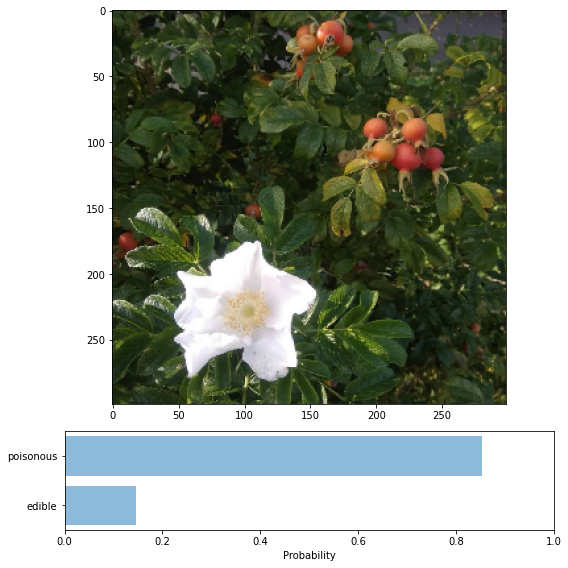

In [ ]:
img = image.load_img('ncX0t_t-pew.jpg', target_size=(HEIGHT, WIDTH))
preds = predict(model, img)

plot_preds(np.asarray(img), preds)
preds

In [ ]:
!wget https://sun9-44.userapi.com/sh3Is5OjaRwC2nTgVx1hE26CF396dAUfCLYw0Q/B5bytFCQvXo.jpg
!ls

--2020-07-21 11:55:57--  https://sun9-44.userapi.com/sh3Is5OjaRwC2nTgVx1hE26CF396dAUfCLYw0Q/B5bytFCQvXo.jpg
Resolving sun9-44.userapi.com (sun9-44.userapi.com)... 93.186.227.151
Connecting to sun9-44.userapi.com (sun9-44.userapi.com)|93.186.227.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 489368 (478K) [image/jpeg]
Saving to: ‘B5bytFCQvXo.jpg’

B5bytFCQvXo.jpg     100%[===================>] 477.90K  --.-KB/s    in 0.1s    

2020-07-21 11:55:57 (3.25 MB/s) - ‘B5bytFCQvXo.jpg’ saved [489368/489368]

0701w-4.jpg			      filename_class.h5
9e6152f732a225a3f54987f10d480f0c.jpg  filename.h5
B1f43Yw23Vc.jpg			      Good
B5bytFCQvXo.jpg			      Grib.zip
Bad				      hXtEJLiS8Pg.jpg
Berry1.zip			      kanttarelli-keltavahvero.jpg
Berry.ipynb			      l0KDUUGQPyo.jpg
Berry.zip			      mnist_cnn.py
ccanniy_proect.ipynb		      Mushroom
class.ipynb			      ncX0t_t-pew.jpg
class_test			      pLckX_9w4GQ.jpg
class_train			      test
Class.zip			      test_berry
filename

array([0.93505746, 0.0649425 ], dtype=float32)

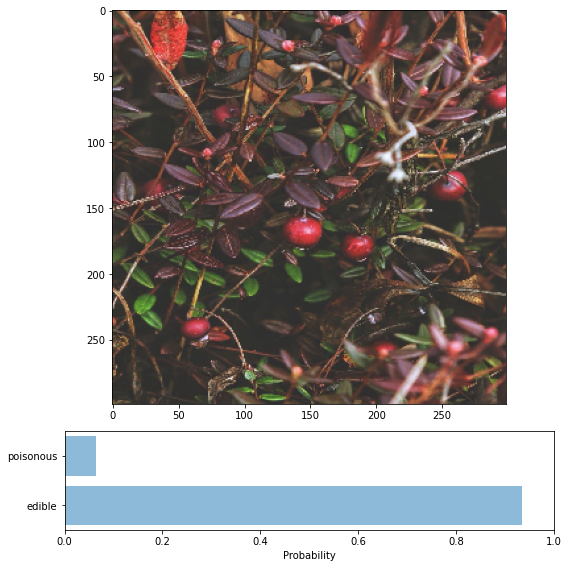

In [ ]:
img = image.load_img('B5bytFCQvXo.jpg', target_size=(HEIGHT, WIDTH))
preds = predict(model, img)

plot_preds(np.asarray(img), preds)
preds

In [ ]:
!wget https://sun9-41.userapi.com/JGhCA8hb4J4kvF8sA9iNsnJrQJCp-5pDP0dksQ/fane8qsFT48.jpg
!ls

--2020-07-21 11:57:13--  https://sun9-41.userapi.com/JGhCA8hb4J4kvF8sA9iNsnJrQJCp-5pDP0dksQ/fane8qsFT48.jpg
Resolving sun9-41.userapi.com (sun9-41.userapi.com)... 93.186.227.148
Connecting to sun9-41.userapi.com (sun9-41.userapi.com)|93.186.227.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 452946 (442K) [image/jpeg]
Saving to: ‘fane8qsFT48.jpg’

fane8qsFT48.jpg     100%[===================>] 442.33K  --.-KB/s    in 0.1s    

2020-07-21 11:57:13 (2.98 MB/s) - ‘fane8qsFT48.jpg’ saved [452946/452946]

0701w-4.jpg			      filename_class.h5
9e6152f732a225a3f54987f10d480f0c.jpg  filename.h5
B1f43Yw23Vc.jpg			      Good
B5bytFCQvXo.jpg			      Grib.zip
Bad				      hXtEJLiS8Pg.jpg
Berry1.zip			      kanttarelli-keltavahvero.jpg
Berry.ipynb			      l0KDUUGQPyo.jpg
Berry.zip			      mnist_cnn.py
ccanniy_proect.ipynb		      Mushroom
class.ipynb			      ncX0t_t-pew.jpg
class_test			      pLckX_9w4GQ.jpg
class_train			      test
Class.zip			      test_berry
fane8qsF

array([9.9967420e-01, 3.2586989e-04], dtype=float32)

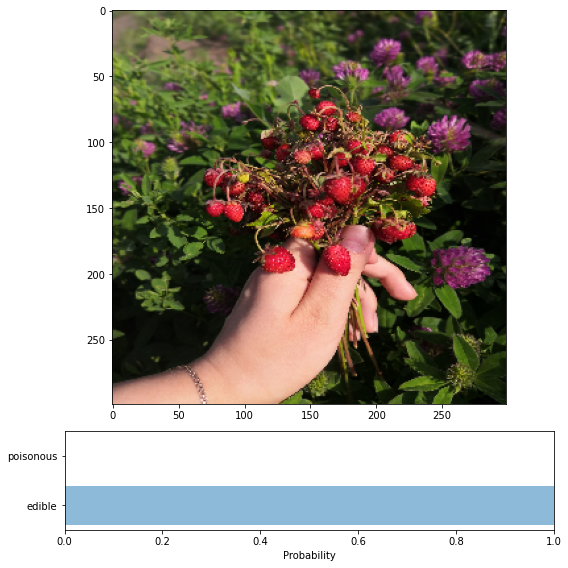

In [ ]:
img = image.load_img('fane8qsFT48.jpg', target_size=(HEIGHT, WIDTH))
preds = predict(model, img)

plot_preds(np.asarray(img), preds)
preds

In [ ]:
!wget https://sun1-97.userapi.com/F4psOSsiQ56F9sexM1zEcoGncjovKr16v4wTng/JgGqYTjWmUk.jpg
!ls

--2020-07-21 11:58:07--  https://sun1-97.userapi.com/F4psOSsiQ56F9sexM1zEcoGncjovKr16v4wTng/JgGqYTjWmUk.jpg
Resolving sun1-97.userapi.com (sun1-97.userapi.com)... 95.142.204.153
Connecting to sun1-97.userapi.com (sun1-97.userapi.com)|95.142.204.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 373145 (364K) [image/jpeg]
Saving to: ‘JgGqYTjWmUk.jpg’

JgGqYTjWmUk.jpg     100%[===================>] 364.40K  2.13MB/s    in 0.2s    

2020-07-21 11:58:07 (2.13 MB/s) - ‘JgGqYTjWmUk.jpg’ saved [373145/373145]

0701w-4.jpg			      filename_class.h5
9e6152f732a225a3f54987f10d480f0c.jpg  filename.h5
B1f43Yw23Vc.jpg			      Good
B5bytFCQvXo.jpg			      Grib.zip
Bad				      hXtEJLiS8Pg.jpg
Berry1.zip			      JgGqYTjWmUk.jpg
Berry.ipynb			      kanttarelli-keltavahvero.jpg
Berry.zip			      l0KDUUGQPyo.jpg
ccanniy_proect.ipynb		      mnist_cnn.py
class.ipynb			      Mushroom
class_test			      ncX0t_t-pew.jpg
class_train			      pLckX_9w4GQ.jpg
Class.zip			      test
fan

array([9.9999964e-01, 3.7290599e-07], dtype=float32)

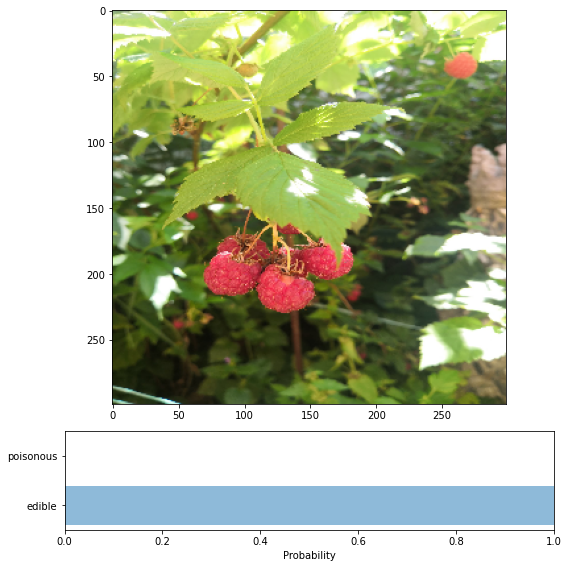

In [ ]:
img = image.load_img('JgGqYTjWmUk.jpg', target_size=(HEIGHT, WIDTH))
preds = predict(model, img)

plot_preds(np.asarray(img), preds)
preds

array([0.55865514, 0.44134486], dtype=float32)

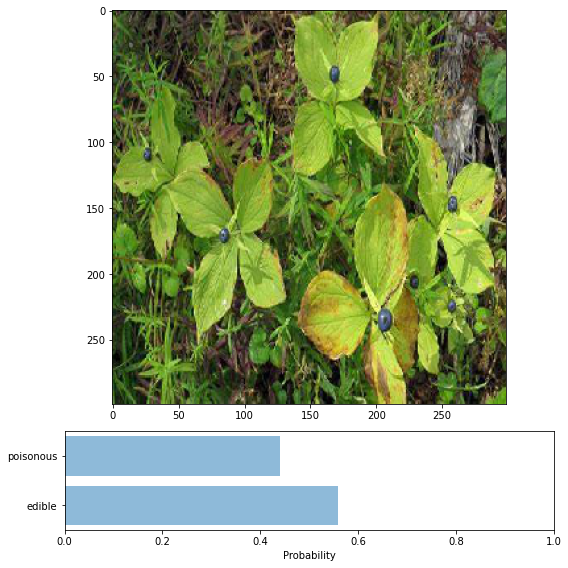

In [ ]:
img = image.load_img('/content/drive/My Drive/проект/berry_test/Ine/voroni.jpg', target_size=(HEIGHT, WIDTH))
preds = predict(model, img)

plot_preds(np.asarray(img), preds)
preds